# Import necessary libraries

In [3]:
import os
import warnings  # To ignore any warnings warnings.filterwarnings("ignore")
from glob import glob  # glob uses the wildcard pattern to create an iterable object file names # containing all matching file names in the current directory.

import numpy as np  # For mathematical calculations
import pandas as pd  # For Pandas DataFrame
from scipy.stats import kurtosis, skew  # To calculate skewness, kurtosis

import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
plt.rcParams['font.size'] = 22
%matplotlib inline 
import warnings                        # To ignore any warnings warnings.filterwarnings("ignore")

import pickle
import errno

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [ ]:
os.listdir("./../dataset")

# Feature Extraction

In [ ]:
def main(train_label_df, feature, data_flag):
    #list all subject's data floder
    folders = os.listdir("./../dataset/" + data_flag)
    
    df = pd.DataFrame()

    for folder in set(folders):
        # read all the datasets one by one for each subject in the directory listing
        data_df = pd.DataFrame(fetch_train_data(folder , feature))
        
        # add the labels to training data
        if(data_flag == 'train'):
            data_df['activity'] = train_label_df.loc[train_label_df.Subject == folder]['Label'].to_list()
        
        # append each subject's dataframe to a common dataframe
        df = df.append(data_df, ignore_index=True)

    # random shuffling of all test/train data
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.add_prefix(feature+"_")

    # write the file with extracted features
    out_file = "./../dataset/pickle/"+ data_flag +"/"+ feature +".pickle"
    if not os.path.exists(os.path.dirname(out_file)):
        try:
            os.makedirs(os.path.dirname(out_file))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

    pickle_out = open(out_file,"wb")
    pickle.dump(df, pickle_out)

    print("Excuted Successfully")

# Here is the function to fecth the summarised training data of each subject
def fetch_train_data(folder, feature):
    column_names = ['EMG1'
                ,'EMG2'
                ,'EMG3'
                ,'EMG4'
                ,'Airborne'
                ,'ACC upper X'
                ,'ACC upper Y'
                ,'ACC upper Z'
                ,'Goniometer X'
                ,'ACC lower X'
                ,'ACC lower Y'
                ,'ACC loewr Z'
                ,'Goniometer Y'
                ,'gyro upper X'
                ,'gyro upper Y'
                ,'gyro upper Z'
                ,'gyro lower X'
                ,'gyro lower Y'
                ,'gyro lower Z'
            ]
    # DataFrame to hold each processed dataset
    dataframe = pd.DataFrame()
    
    # filenames: holds all the activity files given subject
    file_names = glob("./../dataset/" + data_flag + "/" + folder +"/*.csv")
    
    #read each activity file of the subject
    for file_name in file_names:
        df = pd.read_csv(file_name, names =column_names, header=None)
            
        #append the processed dataset to dataframe 
        dataframe = dataframe.append(extract_features(df, feature), ignore_index=True)
    
    return dataframe
    
def extract_features(df, feature):
    stats_df = pd.DataFrame()
    switcher_df = df
    stats_df = time_stats(switcher_df, feature)  
    return(stats_df.transpose())

def time_stats(switcher_df, switcher_feature):
    switcher={
        'mean': switcher_df.mean(),
        'median': switcher_df.median(),
        'min': switcher_df.min(),
        'max': switcher_df.max(),
        'std': switcher_df.std(),
        'variance': switcher_df.var(),
        'mad': switcher_df.mad(),
        'rms': np.sqrt(np.sum(np.power((switcher_df),2))/len(switcher_df)),
        'zcr': np.diff(np.signbit(switcher_df)).sum(),
        'iqr': switcher_df.quantile(0.75) - switcher_df.quantile(0.25),
        'pe': switcher_df.quantile(0.75),
        'kurtosis': kurtosis(switcher_df),
        'skew': skew(switcher_df)
     }
    return switcher.get(switcher_feature,"Invalid feature")

    
if __name__ == '__main__':
    # read labled training data
    train_label_df = pd.read_csv("./../dataset/train.csv")
    
    # flag is to determine test and train data
    data_flag = 'train'
    
    # Select required feature from the below set
    # {'mean','median','min','max','std','variance','mad','rms','zcr','iqr','pe','kurtosis','skew'}
    
    features = ['mean','median','min','max','std','variance','mad','rms','iqr','pe']
    
    for feature in features:
        main(train_label_df, feature, data_flag)

### Join all the features together

In [4]:
main_df = pd.DataFrame()
in_file = "./../dataset/pickle/train/mean.pickle"
pickle_in = open(in_file,"rb")
main_df = pickle.load(pickle_in)
main_df.head()

features = ['median','min','max','std','variance','mad','rms','iqr','pe']

for feature in features:
    df = pd.DataFrame()
    in_file = "./../dataset/pickle/train/" + feature +".pickle"
    pickle_in = open(in_file,"rb")
    df = pickle.load(pickle_in)
    df = df.drop([feature+'_activity'], axis=1)
    main_df = pd.merge(main_df, df, left_index=True, right_index=True)
    del(df)
print(main_df.shape)

(6401, 191)


In [5]:
main_df.rename(columns={'mean_activity': 'activity'}, inplace=True)
main_df.shape

(6401, 191)

# Feature Selection

Feature selection methods
- Univariate selection
    
    Statistical tests can be used to select those features that have the strongest relationships with the output variable. The scikit-learn library provides the SelectKBest class, which can be used with a suite of different statistical tests to select a specific number of features.
    
    
- Recursive Feature Elimination (RFE)

    RFE works by recursively removing attributes and building a model on attributes that remain. It uses model accuracy to identify which attributes (and combinations of attributes) contribute the most to predicting the target attribute.
    
    
- Principle Component Analysis (PCA)

    PCA uses linear algebra to transform the dataset into a compressed form. Generally, it is considered a data reduction technique. A property of PCA is that you can choose the number of dimensions or principal components in the transformed result.
    
    
- Choosing important features (feature importance)

    Feature importance is the technique used to select features using a trained supervised classifier. When we train a classifier such as a decision tree, we evaluate each attribute to create splits; we can use this measure as a feature selector.


## Filter Methods

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. The correlation is a subjective term here. For basic guidance, you can refer to the following table for defining correlation co-efficients.

    Pearson’s Correlation: It is used as a measure for quantifying linear dependence between two continuous variables X and Y. Its value varies from -1 to +1.

    LDA: Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

    ANOVA: ANOVA stands for Analysis of variance. It is similar to LDA except for the fact that it is operated using one or more categorical independent features and one continuous dependent feature. It provides a statistical test of whether the means of several groups are equal or not.

    Chi-Square: It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.

One thing that should be kept in mind is that filter methods do not remove multicollinearity. So, you must deal with multicollinearity of features as well before training models for your data.

The main takeaways from this notebook are:

Going from 1465 total features to 536 and an AUC ROC of 0.783 on the public leaderboard
A further optional step to go to 342 features and an AUC ROC of 0.782
The full set of features was built in Part One and Part Two of Manual Feature Engineering

We will use three methods for feature selection:

- Remove collinear features
- Remove features with greater than a threshold percentage of missing values
- Keep only the most relevant features using feature importances from a model

We will also take a look at an example of applying PCA although we will not use this method for feature reduction.

In [6]:
# Seperate the response variable from predicotr variables
features_df = main_df.drop(['activity'], axis=1)
target = main_df['activity']

### Remove features with greater than a threshold percentage of missing values

In [7]:
features_missing = (features_df.isnull().sum() / len(features_df)).sort_values(ascending = False)
print(features_missing.head())

pe_gyro upper Z     0.0
max_ACC lower Y     0.0
max_Goniometer X    0.0
max_EMG4            0.0
max_EMG3            0.0
dtype: float64


In [8]:
# Identify missing values above threshold
features_missing = features_missing.index[features_missing > 0]
print('There are {} columns with missing values'.format(len(features_missing)))

There are 0 columns with missing values


### Remove collinear features

Irrelevant features, highly correlated features, and missing values can prevent the model from learning and decrease generalization performance on the testing data. Therefore, we perform feature selection to keep only the most useful variables.

We will start feature selection by focusing on collinear variables.

In [83]:
from sklearn.model_selection import train_test_split

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    main_df.drop(['activity'], axis=1),
    main_df['activity'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((4480, 190), (1921, 190))

In [101]:
# Encoding the categorical Target variables
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
    
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [11]:
y_train

array([17, 11, 12, ..., 19,  7,  4])

In [102]:
y_train.shape, y_test.shape

((4480,), (1921,))

In [13]:
# find and remove correlated features
# in order to reduce the feature space a bit
# so that the algorithm takes shorter to find
# the features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)))

correlated features:  19


In [45]:
# remove correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((4480, 171), (1921, 171))

19 correlated features are removed. Now therea are 171 features remaining

Regularisation for Feature Selection:

Regularisation consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and in other words to avoid overfitting. 

Using Lasso shrinkage method

In [126]:
from sklearn.preprocessing import StandardScaler

# standardize the data for numerical precision for linear models (lasso regularization)
X_train_scaled=minmax_scale(X_train)

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# first specify the Lasso Regression model, and then select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then I use the selectFromModel object from sklearn, which will select the features which coefficients are non-zero

feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0))
feature_sel_model.fit(X_train_scaled, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [20]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(feature_sel_model.estimator_.coef_ == 0)))

total features: 171
selected features: 164
features with coefficients shrank to zero: 7


In [66]:
X_train =  X_train[selected_feat]

In [39]:
X_train.shape

(4480, 164)

In [49]:
features_df
target.values

array(['stand', 'lateral-shuffle-left', 'v-cut-right-Lfirst', ..., 'run',
       'curve-left-step', 'v-cut-left-Rfirst'], dtype=object)

In [50]:
import joblib
import pickle

import numpy as np  # For mathematical calculations
import pandas as pd  # For Pandas DataFrame

from sklearn import metrics, model_selection, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

Using Pipeline and GridSearchCV to perform hyper parameter tuning in order to determine the optimal values for a given models.

In [51]:
y_train = target.values
    
x_train = features_df

le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)

pipeline_lr = Pipeline([('scaler1',StandardScaler()), ('clf',LogisticRegression(multi_class='auto', random_state=42))])

pipeline_randomforest = Pipeline([('scaler2',StandardScaler()), ('clf',RandomForestClassifier())])

pipeline_xgboost = Pipeline([('scaler2',StandardScaler()), ('clf', xgb.XGBClassifier())])

model_pipeline = [pipeline_lr, pipeline_randomforest, pipeline_xgboost]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'RandomForest', 2: 'XGboost'}

parameters = [{
                 'clf__penalty': ['l2'],
                 'clf__C': np.logspace(0, 4, 10)
                },
                {
                 'clf__n_estimators': [10, 30],
                 'clf__max_features': [0.25, 1.0]
                },
                {'clf__nthread': [4], #when use hyperthread, xgboost may become slower
                'clf__objective': ['binary:logistic'],
                'clf__learning_rate': [0.05], #so called `eta` value
                'clf__max_depth': [6],
                'clf__min_child_weight': [11],
                'clf__silent': [1],
                'clf__subsample': [0.8],
                'clf__colsample_bytree': [0.7],
                'clf__n_estimators': [5], #number of trees, change it to 1000 for better results
                'clf__seed': [1337]}
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]}
              ]

# fit the pipeline with the training data
for model, pipe in zip(model_pipeline, pipe_dict):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters[pipe], cv = model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=42) )
    grid_search.fit(x_train, y_train)

    joblib.dump(grid_search, f"./../models/{pipe_dict[pipe]}.pkl")

    print("{}: model best parameters are --> {}".format(pipe_dict[pipe], grid_search.best_params_))

    print("{}: cv accuracy is  {}".format(pipe_dict[pipe], grid_search.best_score_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Logistic Regression: model best parameters are --> {'clf__C': 2.7825594022071245, 'clf__penalty': 'l2'}
Logistic Regression: cv accuracy is  0.40024996094360255
RandomForest: model best parameters are --> {'clf__max_features': 0.25, 'clf__n_estimators': 30}
RandomForest: cv accuracy is  0.898140915481956
XGboost: model best parameters are --> {'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__min_child_weight': 11, 'clf__n_estimators': 5, 'clf__nthread': 4, 'clf__objective': 'binary:logistic', 'clf__seed': 1337, 'clf__silent': 1, 'clf__subsample': 0.8}
XGboost: cv accuracy is  0.595219496953601


The best model and parameters determined from GridSearchCV are the following
- Estimator: RandomForest
- Hyperparameters: 'max_features': 0.25, 'n_estimators': 30

Now we find the number features at which we get best performance

To find the best number of features for the model.

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

In [74]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
RandomForest_clf = RandomForestClassifier(max_features=0.25, n_estimators=30)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=RandomForest_clf, step=20, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(x_train, y_train)

Optimal number of features : 18


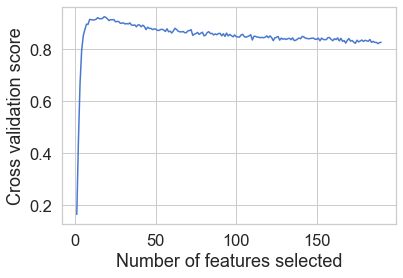

In [73]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig('./../report/Feature Selection.png', dpi=300, bbox_inches='tight')
plt.show()

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model_rf = RandomForestClassifier(n_estimators=30, 
                               bootstrap = True,
                               max_features = 18)
# Fit on training data
model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=18, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [82]:
test_data = pd.read_csv("./../dataset/challenge_labels.csv")
test_data.head()

,Subject,Datafile,Label
0,Subject01,Subject01/Subject01_Aufnahme000.csv,curve-right-step
1,Subject01,Subject01/Subject01_Aufnahme001.csv,v-cut-right-Lfirst
2,Subject01,Subject01/Subject01_Aufnahme002.csv,curve-left-spin-Lfirst
3,Subject01,Subject01/Subject01_Aufnahme003.csv,stand-to-sit
4,Subject01,Subject01/Subject01_Aufnahme004.csv,stair-down


In [88]:
# Actual class predictions
rf_predictions = model_rf.predict(X_test)
# Probabilities for each class
rf_probs = model_rf.predict_proba(X_test)[:, 1]

ROC-AUC score is meant for classification problems where the output si probability of the input belonging to a class. If you do a multi-class classification, then you can compute the score for each class independently.

As mentioned in here, to the best of my knowledge there is not yet a way to easily compute roc auc for multiple class settings natively in sklearn.

However, if you are familiar with classification_report you may like this simple implementation that returns the same output as classification_report as a pandas.DataFrame which I personally found it very handy!:

In [123]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
np.set_printoptions(precision=2)

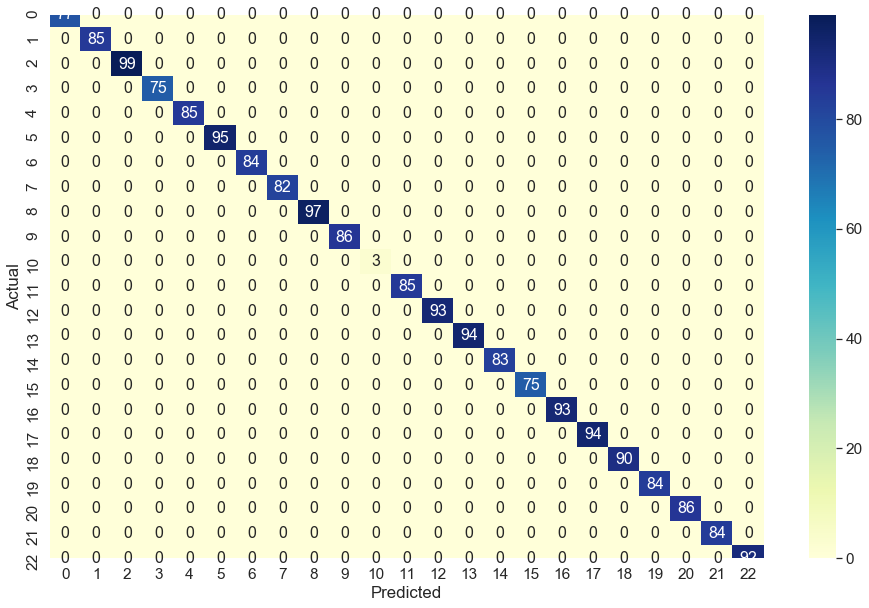

In [127]:
cm = pd.DataFrame(cnf_matrix, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (16,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size
plt.savefig('./../report/Confusion Matrix.png', dpi=300, bbox_inches='tight')

In [106]:
#Metrics definition.
def accuracy(confusion_matrix):
    sum_diagonal=sum(np.diagonal(confusion_matrix))
    total=sum(sum(confusion_matrix))
    return (sum_diagonal/total)

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

In [124]:
print("Overall test accuracy using hypertuned RandomForest model is {}".format(accuracy(conf_matrix)))

Overall test accuracy using hypertuned RandomForest model is 1.0
